# 强化学习


## **概述**  
![rl](./images/rl.png)

强化学习是一种机器学习方法，专注于**智能体 (Agent) 在环境 (Environment) 中通过试错 (Trial and Error) 学习最优策略**。它的核心目标是让智能体通过与环境交互，**最大化累积奖励 (Cumulative Reward)**。强化学习广泛应用于**机器人控制、游戏 AI、自动交易、推荐系统**等领域。

强化学习不同于**监督学习**（需要标注数据）和**无监督学习**（发现数据结构），它更像**一个智能体在环境中不断探索，学习如何行动以获得最大回报**。

### **关键概念**
1. **Agent（智能体）**  
   - 负责**决策**并执行动作的主体（如机器人、游戏角色、自动驾驶系统）。
   - 它的目标是根据环境的反馈不断调整自己的策略，使得长期回报最大化。

2. **Environment（环境）**  
   - 智能体所在的**世界**，它会根据智能体的动作给出反馈（奖励和新状态）。
   - 例如，自动驾驶汽车的环境可以是**道路、行人、红绿灯等**。

3. **State（状态, S）**  
   - 描述智能体当前所处的**环境信息**。
   - 例如，**游戏 AI 的状态可以是棋盘布局，自动驾驶的状态可以是摄像头图像和传感器数据**。
   - **状态一般是环境的一个表示，用于智能体决策**。

4. **Action（动作, A）**  
   - 智能体可以采取的**所有可能的操作**。
   - 例如，**机器人可以选择前进、转向、停止；棋类 AI 可以选择下一步棋**。
   - **智能体通过执行动作影响环境，从而获得新的状态和奖励**。

5. **Reward（奖励, R）**  
   - 智能体执行某个动作后，环境返回的**反馈信号**，用于衡量当前决策的好坏。
   - 例如，在游戏 AI 里，赢得比赛可以给正奖励 ( +1 )，而输掉比赛可能给负奖励 ( -1 )。
   - **智能体的目标是最大化长期奖励，而不仅仅是短期奖励**。

## 多臂老虎机问题
> 从实际问题出发来对强化学习中的关键概念有个认知。

### 定义

有一个拥有X根拉杆的老虎机，拉动每一根拉杆都对应一个关于奖励的概率分布 。每次拉动其中一根拉杆，就可以从该拉杆对应的奖励概率分布中获得一个奖励 。我们在各根拉杆的奖励概率分布未知的情况下，从头开始尝试，目标是在操作  次拉杆后获得尽可能高的累积奖励。由于奖励的概率分布是未知的，因此我们需要在“探索拉杆的获奖概率”和“根据经验选择获奖最多的拉杆”中进行权衡。“采用怎样的操作策略才能使获得的累积奖励最高”便是多臂老虎机问题。如果是你，会怎么做呢？

![mab](./images/multi-armed-bandit.png)



In [9]:
import numpy as np
import matplotlib.pyplot as plt


class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """
    def __init__(self, K):
        """ 
        初始化逻辑：
        1. 生成一个长度为K的数组probs，每个元素是[0,1)区间的均匀分布随机数，代表每根拉杆的获奖概率。
        2. 找到获奖概率最大的拉杆索引best_idx及其对应的概率best_prob。
        3. 存储拉杆数量K。"""
        self.probs = np.random.uniform(size=K)
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        self.K = K

    def step(self, k):
        """ 
        动作逻辑：
        1. 当玩家选择第k号拉杆时，生成一个[0,1)的随机数。
        2. 如果随机数小于probs[k]，返回奖励1（获奖），否则返回0（未获奖）。
        """
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0


np.random.seed(1)
K = 30
bandit = BernoulliBandit(K)
print("%d臂伯努利老虎机: 获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
      (K, bandit.best_idx, bandit.best_prob))

30臂伯努利老虎机: 获奖概率最大的拉杆为21号,其获奖概率为0.9683


In [10]:
class Solver:
    def __init__(self, bandit):
        """
        初始化:
        counts：长度为 K 的数组，记录每个拉杆被选择的次数。
        regret：累积懊悔值，衡量算法因未始终选择最佳拉杆而损失的奖励总和。
        actions：记录每一步选择的拉杆编号。
        regrets：记录每一步的累积懊悔值，用于后续分析画图。
        """
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)
        self.regret = 0.
        self.actions = []
        self.regrets = []

    def update_regret(self, k):
        """
        更新懊悔值:
        计算单步懊悔：best_prob 是最优拉杆的获奖概率，probs[k] 是当前选择拉杆的获奖概率，best_prob - probs[k] 表示这一步因未选择最优拉杆的损失。
        更新累积懊悔：将单步懊悔累加到 self.regret。
        记录历史懊悔：将当前累积懊悔值添加到 regrets 列表中，用于后续分析。
        """
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

In [11]:
class EpsilonGreedy(Solver):
    """ 
    epsilon:
    探索（Exploration）：以概率 ε 随机选择一个动作（拉杆），尝试未知或较少尝试的选项。
    利用（Exploitation）：以概率 1-ε 选择当前已知最优动作（即 estimates 值最大的拉杆），最大化当前收益。
    平衡目标：通过调整 ε 的取值，控制算法在“尝试新动作”和“选择已知最优动作”之间的权衡。
    """
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        #初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(k)  # 得到本次动作的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k


class DecayingEpsilonGreedy(Solver):
    """
    衰减epsilon贪婪算法:
    初始高探索率（如 ε=1），随时间逐步降低。结合了早期探索和后期利用的优势。
    """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k



def plot_results(solvers, solver_names):
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()   

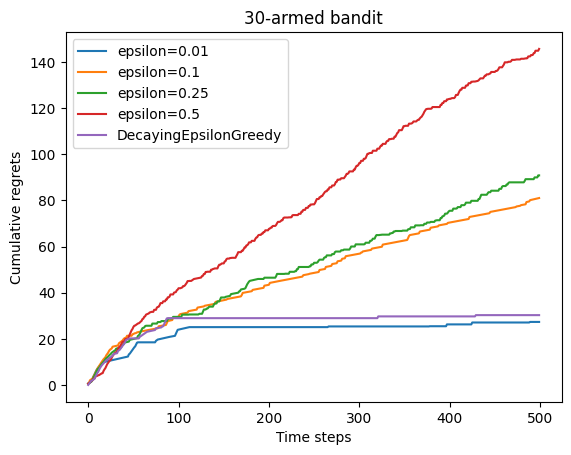

In [12]:
np.random.seed(0)
epsilons = [0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_30_arm, epsilon=e) for e in epsilons
]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(500)

decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_30_arm)
decaying_epsilon_greedy_solver.run(500)

epsilon_greedy_solver_list.append(decaying_epsilon_greedy_solver)
epsilon_greedy_solver_names.append("DecayingEpsilonGreedy")

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

### 总结

多臂老虎机是**无状态**强化学习的简化模型，与真正的一大区别在于其与环境的交互并**不会改变环境**。但是它有助于我们学习强化学习的关键概念:

| **概念**          | **多臂老虎机**                          | **经典强化学习**                       |
|---------------------|----------------------------------------|----------------------------------------|
| **Agent(智能体)**   | 选择拉杆的决策主体（如 `Solver` 类及其子类）     | 机器人、游戏角色等，通过策略网络或算法选择动作 |
| **Environment(环境)** | 老虎机本身，提供拉杆的奖励概率 | 游戏、物理世界等，接收动作并返回奖励和状态（如自动驾驶中的道路环境)|
| **State(状态)**       | 当前对拉杆奖励的估计值（`estimates` 数组)| 显式状态（如机器人传感器数据、棋盘布局），动态变化且影响后续奖励 |
| **Action(动作)**     | 选择拉杆的编号（如 `k` 值） | 机器人移动、棋类落子等，动作可能影响后续状态       |
| **Reward(奖励)**     | 拉动拉杆后获得的即时奖励（0 或 1） | 环境返回的反馈信号（如游戏得分、自动驾驶中的安全奖励）       |

---
